In [1]:
# K-Means, CURE, DBSCAN
#!pip install pyclustering
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from pyclustering.cluster.cure import cure
from pyclustering.cluster import cluster_visualizer
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.utils import timedcall
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from mpl_toolkits import mplot3d
from sklearn import metrics
from sklearn.cluster import DBSCAN
%matplotlib inline

df=pd.read_csv('data.csv',encoding='iso-8859-1')
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=fc262e4c472d8d23f34e531c1407795faf3cc22811dcae39f2a4abea2d355ade
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [2]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,137838.000000,137838.000000,94102.000000
mean,8.943695,5.180769,15292.544048
std,288.015005,106.172683,1739.318647
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13869.000000
50%,3.000000,2.460000,15192.000000
75%,10.000000,4.210000,16889.000000
max,74215.000000,16888.020000,18283.000000


<Axes: >

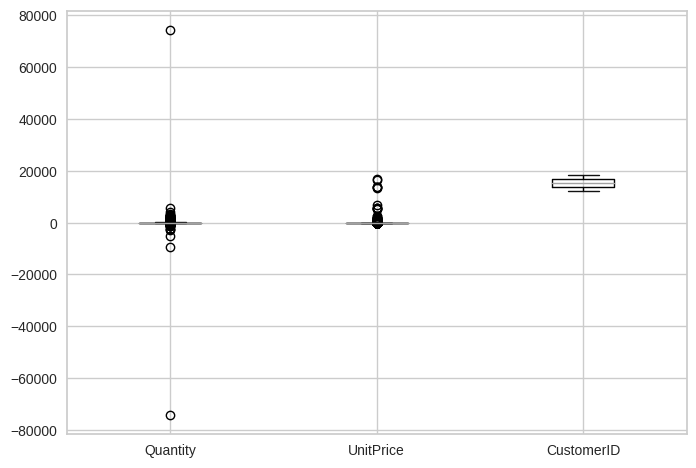

In [3]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot()

In [4]:
df=df.dropna().reset_index()
df = df[df.Quantity <=10000]
df = df[df.Quantity >=0]
df=df.sort_values(['Quantity'],ascending=False)
df.shape

(91787, 9)

<Axes: >

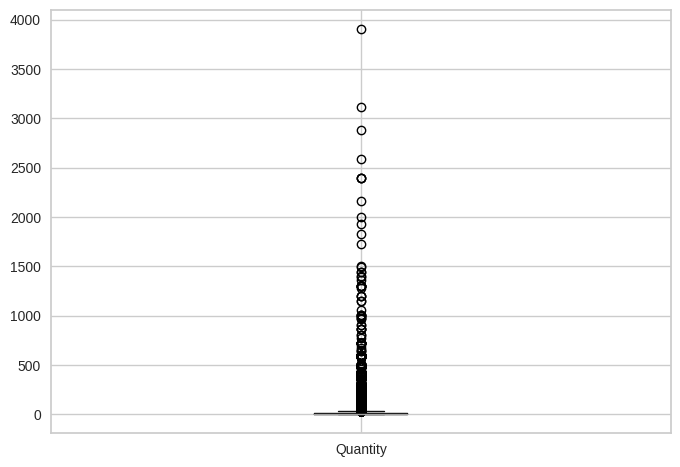

In [6]:
import matplotlib.pyplot as plt

plt.figure()
df.boxplot('Quantity')

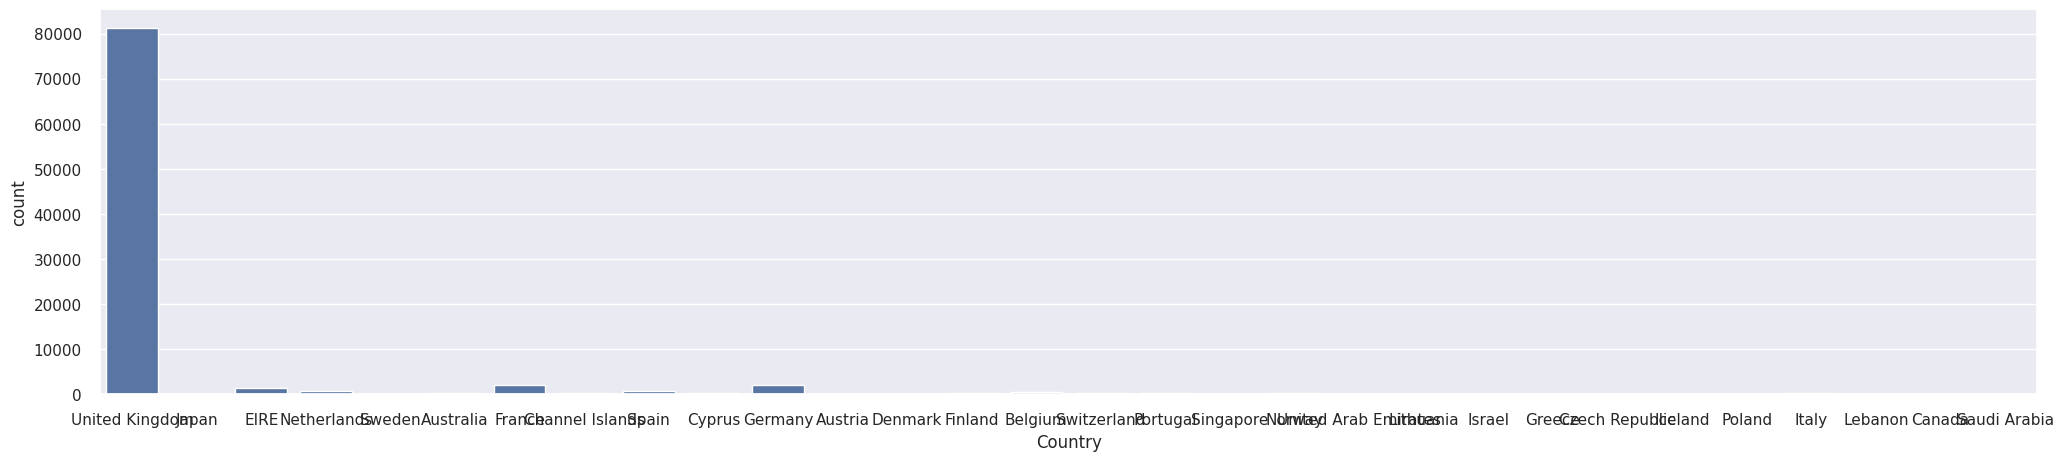

In [7]:
sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Country", data=df)


In [8]:
dfuk=df[df['Country']=='United Kingdom']


In [9]:
dfukg = (dfuk.groupby(['CustomerID','Country'],as_index=False)
          .agg({'InvoiceNo':'nunique', 'StockCode':'nunique','UnitPrice':'mean','Quantity':'sum'}))
dfukg
dfukg.reset_index()
dfukg['avgitems']=dfukg['Quantity']/dfukg['InvoiceNo']
db=dfukg[['InvoiceNo','UnitPrice','avgitems']]

In [10]:
import numpy as np

i=0
while i<=len(db)-1:
    quartile_1, quartile_3 = np.percentile(db['avgitems'], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr *1.5 )
    upper_bound = quartile_3 + (iqr *1.5)

    if db.loc[i,'avgitems']> upper_bound:
        db.loc[i,'outlier']=1
    elif db.loc[i,'avgitems']< lower_bound:
        db.loc[i,'outlier']=1
    else:
        db.loc[i,'outlier']=0
    i=i+1

db

<ipython-input-10-9d13d90e7efa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db.loc[i,'outlier']=0


,InvoiceNo,UnitPrice,avgitems,outlier
0,4,3.307500,111.750000,0.0
1,56,2.458606,74.642857,0.0
2,1,1.626364,146.000000,0.0
3,2,7.650000,35.000000,0.0
4,3,1.551429,204.333333,0.0
...,...,...,...,...
1887,1,3.164286,76.000000,0.0
1888,1,4.230000,41.000000,0.0
1889,1,2.550000,20.000000,0.0
1890,1,4.765000,45.000000,0.0


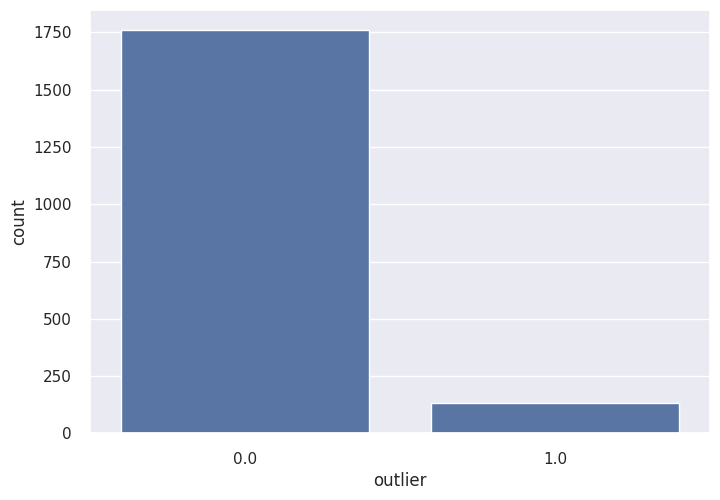

In [11]:
ax = sns.countplot(x="outlier", data=db)

In [12]:
db=db[db['outlier']==0]
db= db.drop(columns=['outlier'])
db

,InvoiceNo,UnitPrice,avgitems
0,4,3.307500,111.750000
1,56,2.458606,74.642857
2,1,1.626364,146.000000
3,2,7.650000,35.000000
4,3,1.551429,204.333333
...,...,...,...
1887,1,3.164286,76.000000
1888,1,4.230000,41.000000
1889,1,2.550000,20.000000
1890,1,4.765000,45.000000


# K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

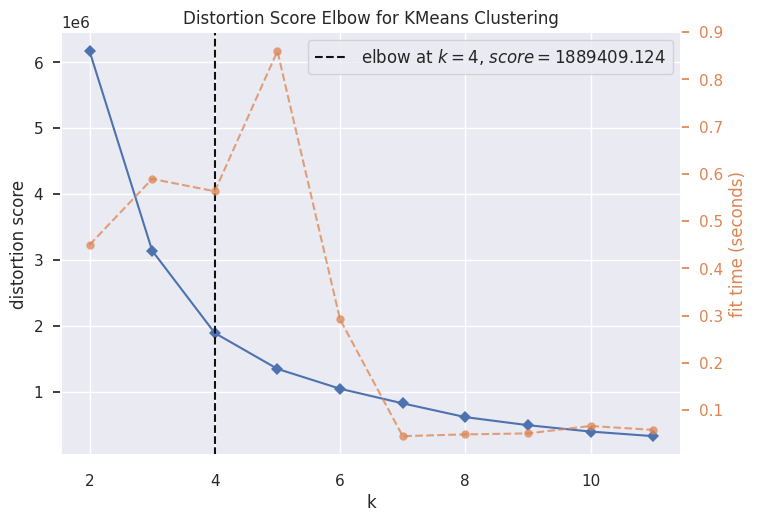

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(db)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  2.18023256   3.08524762 188.22128065]
 [  2.38888889   2.42752081 397.80585328]
 [  2.03508772   6.83681234  50.80759654]
 [  1.99561404   2.80229249 277.97372772]
 [  2.173258     3.23810643 116.20780922]]
[4 2 4 ... 2 2 2]


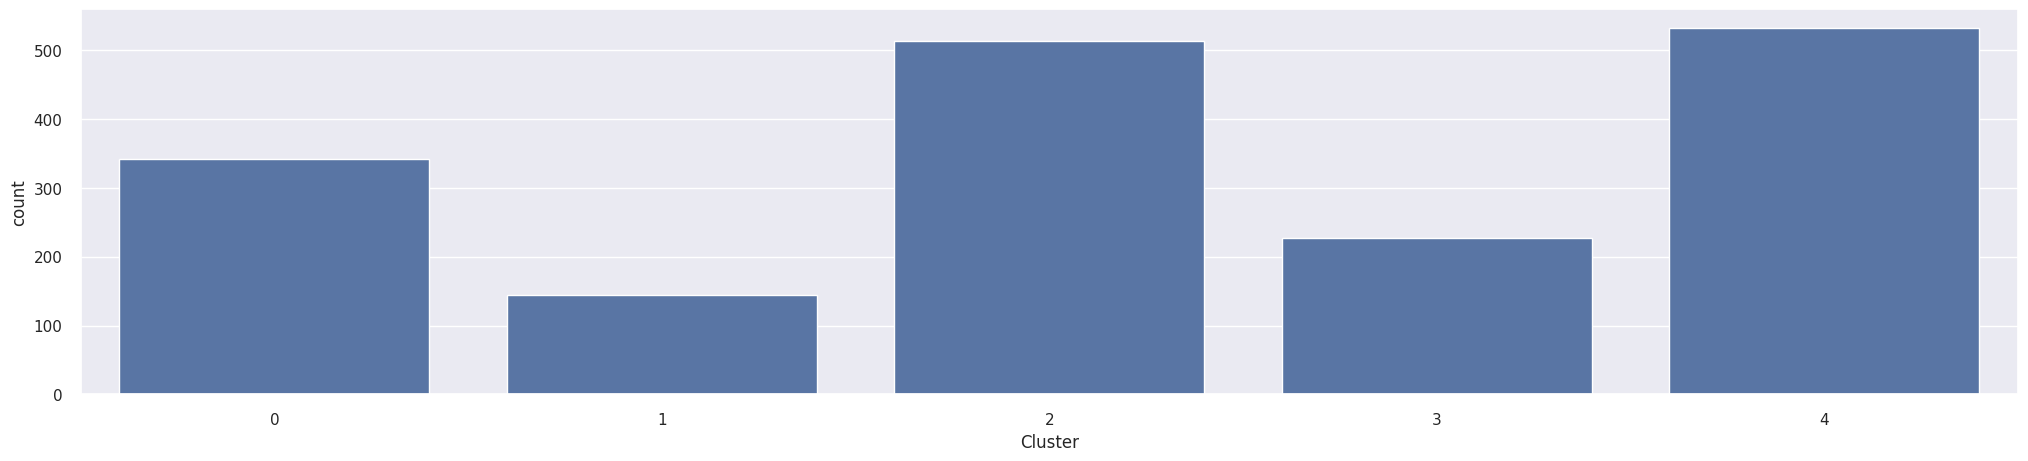

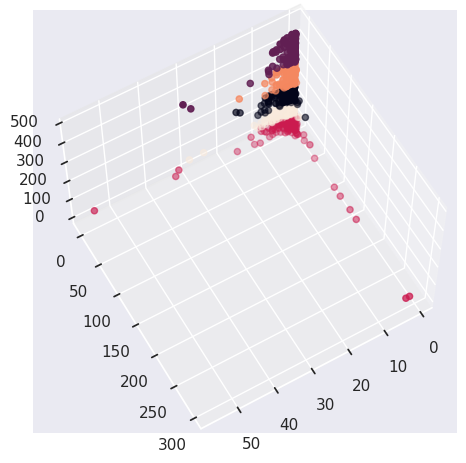

In [14]:
kmeans = KMeans(5)
kmeans.fit(db)
identified_clusters = kmeans.fit_predict(db)
data_with_clusters = db.copy()
data_with_clusters['Cluster'] = identified_clusters
print(kmeans.cluster_centers_)
print(identified_clusters)

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="Cluster", data=data_with_clusters)
data_with_clusters.groupby(['Cluster']).count()
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)

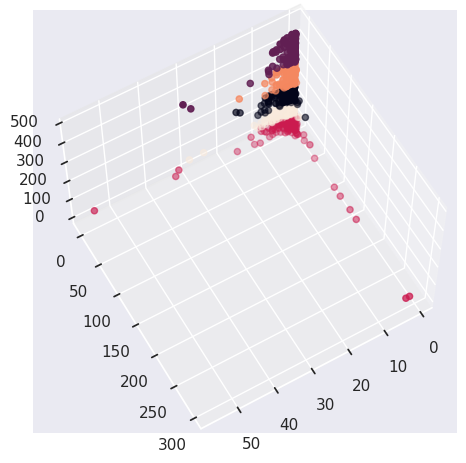

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=data_with_clusters['InvoiceNo']
yline=data_with_clusters['avgitems']
zline=data_with_clusters['UnitPrice']

ax.scatter3D(xline, zline,yline,c=data_with_clusters['Cluster'])
ax.view_init(60, 60)

In [16]:
data_with_clusters[data_with_clusters['Cluster']==4]

,InvoiceNo,UnitPrice,avgitems,Cluster
0,4,3.307500,111.75,4
2,1,1.626364,146.00,4
6,1,3.066667,135.00,4
7,1,4.893889,110.00,4
11,10,2.265254,106.40,4
...,...,...,...,...
1864,1,4.021429,140.00,4
1870,1,3.057674,101.00,4
1879,2,2.765909,139.50,4
1881,4,2.735161,149.50,4


In [17]:
kmeans.cluster_centers_

array([[  2.18023256,   3.08524762, 188.22128065],
       [  2.38888889,   2.42752081, 397.80585328],
       [  2.03508772,   6.83681234,  50.80759654],
       [  1.99561404,   2.80229249, 277.97372772],
       [  2.173258  ,   3.23810643, 116.20780922]])

In [18]:
scaler = StandardScaler()
x_scaled=scaler.fit(db)
x_scaled = scaler.fit_transform(db)
x_scaled

array([[ 0.66838416, -0.06827374, -0.41017528],
       [19.24430825, -0.13836409, -0.76034098],
       [-0.40330377, -0.20707961, -0.08697134],
       ...,
       [-0.40330377, -0.13081801, -1.2759844 ],
       [-0.40330377,  0.05206721, -1.04006911],
       [ 0.31115485, -0.18201561, -0.87650117]])

# CURE Algorithm

clusters: [[2.0336322869955157, 4.828932659985861, 47.39041079491159], [1.0, 137.34375, 3.0], [1.5, 295.0, 1.0], [2.141404805914972, 3.149166576184061, 156.2884511517381], [2.2831858407079646, 2.548906661271698, 366.9318128240116]]
Sample:  pandas.txt 		Execution time:  0.2384230150000235 

[446, 4, 2, 1082, 226]


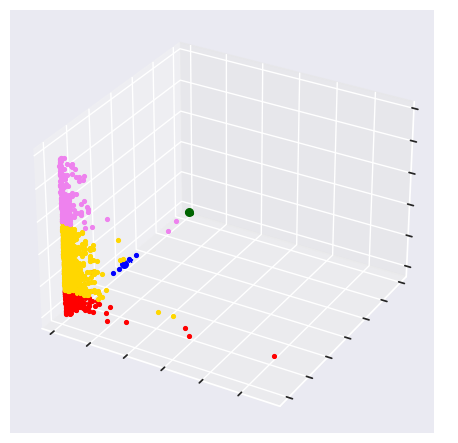

In [20]:
def template_clustering(number_clusters, path, number_represent_points=1, compression=0.5, draw=True, ccore_flag=True):
    sample = read_sample(path)

    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)

    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    print('clusters:',means)
    print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    print([len(cluster) for cluster in clusters])

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()





rec = db.to_records(index=False)
db.to_csv(r'pandas.txt', header=None, index=None, sep=' ', mode='a')
path= 'pandas.txt'
template_clustering(5,path)

In [ ]:
def template_clustering(number_clusters, path, number_represent_points=1, compression=0.5, draw=True, ccore_flag=True):
    sample = read_sample(path)

    cure_instance = cure(sample, number_clusters, number_represent_points, compression, ccore_flag)
    (ticks, _) = timedcall(cure_instance.process)

    clusters = cure_instance.get_clusters()
    representors = cure_instance.get_representors()
    means = cure_instance.get_means()
    print('clusters:',means)
    print("Sample: ", path, "\t\tExecution time: ", ticks, "\n")
    print([len(cluster) for cluster in clusters])

    if draw is True:
        visualizer = cluster_visualizer()

        visualizer.append_clusters(clusters, sample)

        for cluster_index in range(len(clusters)):
            visualizer.append_cluster_attribute(0, cluster_index, representors[cluster_index], '*', 10)
            visualizer.append_cluster_attribute(0, cluster_index, [ means[cluster_index] ], 'o')

        visualizer.show()



dtype = [('Col1','int32'), ('Col2','float32'), ('Col3','float32')]
index = ['Row'+str(i) for i in range(1, len(x_scaled)+1)]

x_sc1 = pd.DataFrame(x_scaled, index=index)

rec = x_sc1.to_records(index=False)
x_sc1.to_csv(r'pa2ndas.txt', header=None, index=None, sep=' ', mode='a')

path= 'pa2ndas.txt'
template_clustering(4,path)